<a href="https://colab.research.google.com/github/rvsvhy/Machine-Learning/blob/main/Machine_Learning_Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sample Entropy: 1.0
Sample Gini: 0.5
Best root feature (from first 5 features): pslist.avg_threads
Decision Tree Accuracy: 0.9991467576791809


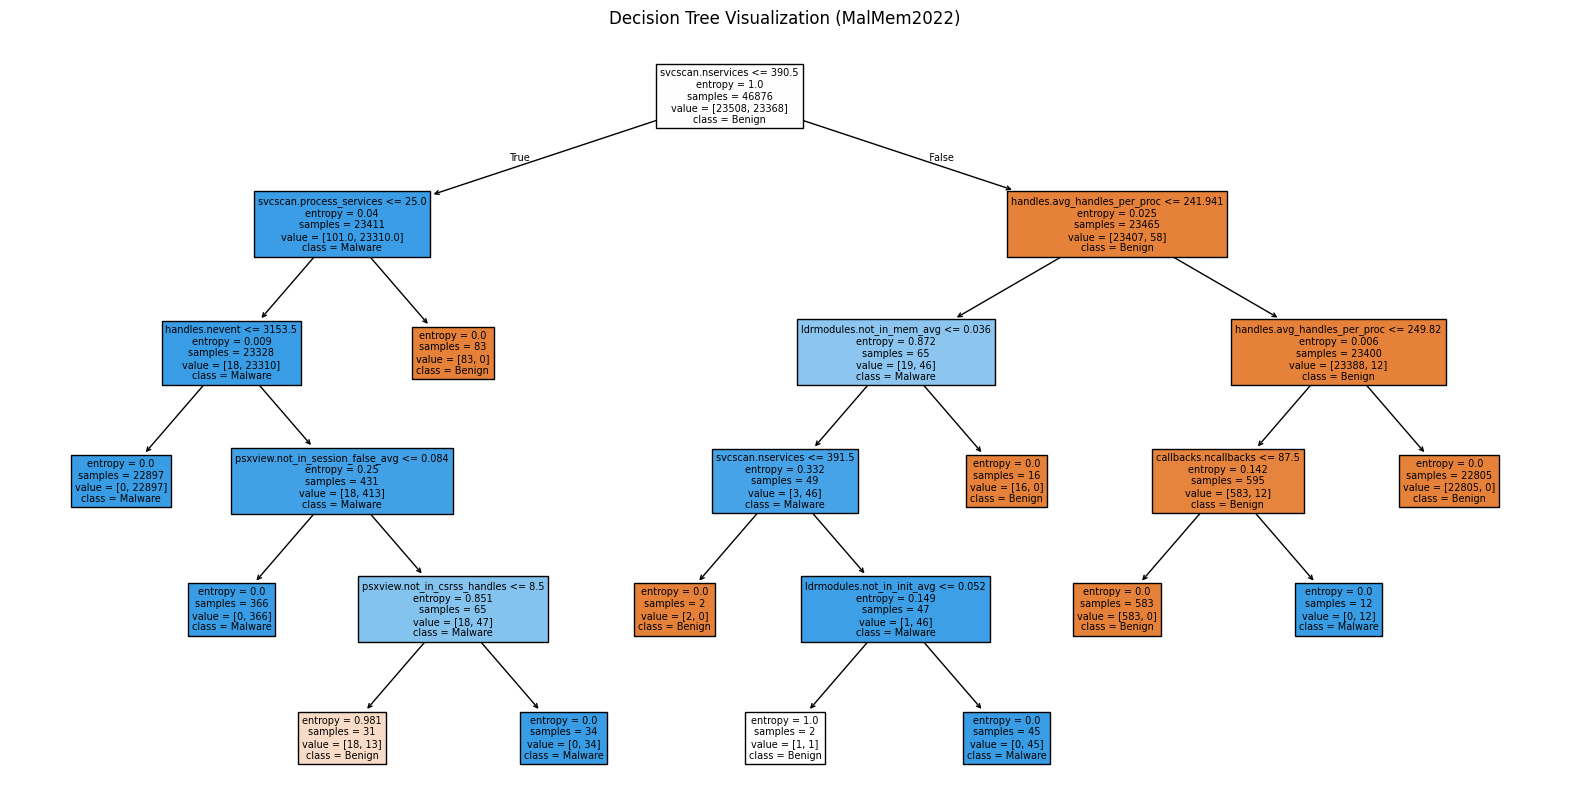

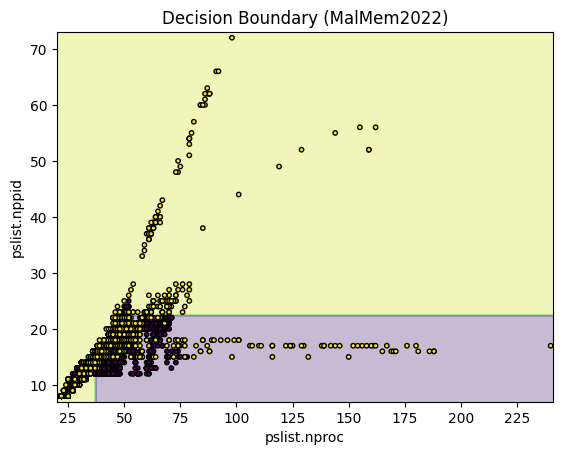

In [3]:
# ================================
# Lab 06 – Decision Tree Assignment (Using Obfuscated-MalMem2022 Dataset)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --------------------------------
# Load dataset
# --------------------------------
df = pd.read_csv("/content/drive/MyDrive/Obfuscated-MalMem2022.csv")

# Encode target labels (Benign = 0, Malicious = 1)
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# Use features + target
X = df.drop(columns=['Category', 'Class'])
y = df['Class']

# --------------------------------
# A1. Entropy Calculation
# --------------------------------
def calculate_entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def equal_width_binning(data, bins=4):
    return pd.cut(data, bins=bins, labels=[f'Bin{i+1}' for i in range(bins)])

print("Sample Entropy:", calculate_entropy(y))

# --------------------------------
# A2. Gini Index Calculation
# --------------------------------
def gini_index(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    gini = 1 - np.sum(probabilities ** 2)
    return gini

print("Sample Gini:", gini_index(y))

# --------------------------------
# A3. Information Gain & Root Node
# --------------------------------
def information_gain(X, y, feature):
    total_entropy = calculate_entropy(y)
    values, counts = np.unique(X[feature], return_counts=True)
    weighted_entropy = 0
    for v, c in zip(values, counts):
        subset_y = y[X[feature] == v]
        weighted_entropy += (c/len(X)) * calculate_entropy(subset_y)
    return total_entropy - weighted_entropy

def best_feature_to_split(X, y):
    gains = {feature: information_gain(X, y, feature) for feature in X.columns}
    return max(gains, key=gains.get), gains

# Example with first 5 features after binning
X_binned = X.copy()
for col in X_binned.columns[:5]:
    X_binned[col] = equal_width_binning(X_binned[col], bins=3)

best, gains = best_feature_to_split(X_binned.iloc[:, :5], y)
print("Best root feature (from first 5 features):", best)

# --------------------------------
# A4. Binning Function (Equal width / Equal frequency)
# --------------------------------
def bin_feature(data, bins=4, method="equal_width"):
    if method == "equal_width":
        return pd.cut(data, bins=bins, labels=[f'Bin{i+1}' for i in range(bins)])
    elif method == "equal_freq":
        return pd.qcut(data, q=bins, labels=[f'Bin{i+1}' for i in range(bins)])
    else:
        raise ValueError("Invalid method: choose 'equal_width' or 'equal_freq'")

# --------------------------------
# A5. Train Decision Tree Classifier
# --------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42)
clf.fit(X_train, y_train)

print("Decision Tree Accuracy:", clf.score(X_test, y_test))

# --------------------------------
# A6. Visualize Tree
# --------------------------------
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=le.classes_)
plt.title("Decision Tree Visualization (MalMem2022)")
plt.show()

# --------------------------------
# A7. Decision Boundary (using 2 features)
# --------------------------------
# Pick two features for visualization
feat1, feat2 = X.columns[:2]
X_2 = X[[feat1, feat2]].values
y_2 = y

clf2 = DecisionTreeClassifier(max_depth=3).fit(X_2, y_2)

x_min, x_max = X_2[:, 0].min() - 1, X_2[:, 0].max() + 1
y_min, y_max = X_2[:, 1].min() - 1, X_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_2[:,0], X_2[:,1], c=y_2, edgecolor='k', s=10)
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title("Decision Boundary (MalMem2022)")
plt.show()
